In [1]:
from pedalboard import Pedalboard, Chorus, Reverb, Distortion
from pedalboard.io import AudioFile
import os
from pathlib import Path

import pandas as pd
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
import IPython.display as ipd

from baselineFCNet import BaselineFCNet
from train_model import train_model
from wav_dataset import WavDataset
from path import *

/home/ivkalu/Documents/DIPL/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def display_audio(input_path: Path):
  input_wav, sr = torchaudio.load(input_path)
  print(f"Displaying: {Path(input_path).name}\nChannels: {input_wav.shape[0]}, Samples {input_wav.shape[1]}")
  display(ipd.Audio(input_path, rate=sr))

In [14]:
display_audio(train_input_files[0])
display_audio(train_output_files[0])

Displaying: 1-E1-Major 00.wav
Channels: 1, Samples 110250


Displaying: 1-E1-Major 00.wav
Channels: 1, Samples 110250


In [ ]:
# Train the model
dataset = WavDataset(train_input_files, train_output_files)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = BaselineFCNet(hidden_size=5, hidden_layers=2)

train_model(model, dataloader, epochs=5, lr=0.001, print_batch=False, name="fc_dist")

In [5]:
# load the model
model = BaselineFCNet(hidden_size=5, hidden_layers=2)
model.load_state_dict(torch.load(os.path.join("../models", f"fc_dist_1.pth")))
model.eval()

BaselineFCNet(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
def test_model(model, input_wav_path, output_wav_path):
    model.eval()

    input_wav, sr = torchaudio.load(input_wav_path)
    num_channels = input_wav.shape[0] # TODO disable stereo support
    input_samples = input_wav.reshape(-1, 1)

    with torch.no_grad():
        output_tensor = model(input_samples)

    output_wav = output_tensor.view(num_channels, -1)
    torchaudio.save(output_wav_path, output_wav, sample_rate=sr)

In [18]:
file = guitar_files_only_test.iloc[5]
test_model(model, os.path.join(test_input_folder, file), os.path.join(model_output_folder, file))

display_audio(os.path.join(test_input_folder, file))
display_audio(os.path.join(test_output_folder, file))
display_audio(os.path.join(model_output_folder, file))

Displaying: guitar-solo-74247.wav
Channels: 1, Samples 673344


Displaying: guitar-solo-74247.wav
Channels: 1, Samples 673344


Displaying: guitar-solo-74247.wav
Channels: 1, Samples 673344


In [23]:
import torchaudio.transforms as T

def waveform_to_spectrogram(waveform, sample_rate=44100, n_mels=128, n_fft=1024, hop_length=512):
    mel_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    return mel_transform(waveform)

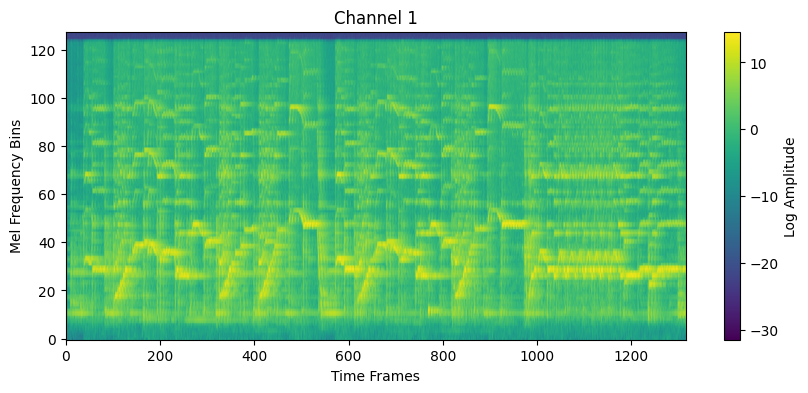

In [ ]:
input_wav_path = os.path.join(test_input_folder, file)
input_wav, sr = torchaudio.load(input_wav_path)
spectrogram = waveform_to_spectrogram(input_wav, sr)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
for i in range(spectrogram.shape[0]):
    plt.subplot(1, spectrogram.shape[0], i + 1)
    plt.imshow(spectrogram[i].log2().detach().numpy(), aspect="auto", origin="lower")
    plt.title(f"Channel {i+1}")
    plt.colorbar(label="Log Amplitude")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.show()

## TODO
- ❌ napravi metrike za mjerit kolko je model dobar, da se kasnije moze lakse usporedit (objektivne metrike)